In [1]:
import numpy as np, pandas as pd, torch, random
import torch.nn as nn
import math
import matplotlib.pyplot as plt

In [2]:
#dataset creation

#seeding for reproducibility
np.random.seed(10)
random.seed(10)


num_samples = 5500 
train_size = 5000


X= []
Y = []

for i in range(num_samples):
    length = random.randint(3, 10) # length range of our examples
    example = np.zeros((length, 2))

    example[:, 0]= np.random.uniform(0, 1, length)
    e1 = random.randint(0, length-1)
    e2 = random.randint(0, length-1)

    while(e2 == e1): #to prevent the example from only having a single element marked as 1
        e2 = random.randint(0, length - 1)

    example[e1, 1] = 1
    example[e2, 1] = 1

    X.append(example)
    sum = np.sum(np.multiply(example[:, 0], example[:, 1]))
    Y.append(sum)


X_train = X[:train_size]
X_test = X[train_size:]
Y_train = Y[:train_size]
Y_test = Y[train_size:]


In [3]:
class ElmanRNN(nn.Module):
    def __init__(self, info_size):
        super().__init__()
        self.info_size = info_size

        self.wxh = nn.Parameter(torch.empty(info_size, 2))
        self.whh = nn.Parameter(torch.empty(info_size, info_size))
        self.why = nn.Parameter(torch.empty(1, info_size))
        self.bh = nn.Parameter(torch.empty(info_size, 1))
        self.by = nn.Parameter(torch.empty(1,1))


        # TODO figure out better init method 
        for wt in self.parameters():
            std = 1.0 / math.sqrt(self.info_size)
            wt.data.uniform_(-std, std)


    def forward(self, input):

        # * X is the whole dataset 
        h = torch.zeros((self.info_size, 1))

        y = torch.zeros((len(input)))
        
        #print("hsize "+str(h.size()))


        for i in range(len(input)):
            for elem in input[i]:

                ip = torch.from_numpy(elem).float()
                h = torch.tanh( torch.matmul(self.wxh, ip).view(self.info_size, 1) + torch.matmul(self.whh, h) + self.bh)

            op = torch.matmul(self.why, h) + self.by

            y[i] = op

        return y





In [4]:
# write the backprop code for it 

# elmrnn = ElmanRNN(info_size=10)

# criterion = torch.nn.functional.mse_loss

# optimizer = torch.optim.Adam(elmrnn.parameters(), lr=0.01) #try out values here 

# epochs = 20

# op = elmrnn(X_test)
# lss = criterion(op, torch.from_numpy(np.array(Y_test)).float())

# print(lss)

# for i in range(epochs):
#     optimizer.zero_grad()
#     output = elmrnn(X_train)    #this is a list 
#     loss = criterion(output,  torch.from_numpy(np.array(Y_train)).float())
#     loss.backward()
#     optimizer.step()
    
#     if(i % 10 == 0):
#         print("Loss at epoch {} is {}".format(i, loss))

# op = elmrnn(X_test)
# lss = criterion(op, torch.from_numpy(np.array(Y_test)).float())

# print(lss)



In [5]:
class LSTM(nn.Module):
    def __init__(self, info_size):
        super().__init__()
        self.info_size = info_size
        self.cell_size = info_size

        #declare weights
        self.Wfh = nn.Parameter(torch.Tensor(self.cell_size, info_size))
        self.Wfx = nn.Parameter(torch.Tensor(self.cell_size, 2))
        self.Wih = nn.Parameter(torch.Tensor(self.cell_size, info_size))
        self.Wix = nn.Parameter(torch.Tensor(self.cell_size, 2))
        self.Wch = nn.Parameter(torch.Tensor(self.cell_size, info_size))
        self.Wcx = nn.Parameter(torch.Tensor(self.cell_size, 2))
        self.Woh = nn.Parameter(torch.Tensor(self.cell_size, info_size))
        self.Wox = nn.Parameter(torch.Tensor(self.cell_size, 2)) 
        self.Wy = nn.Parameter(torch.Tensor(1, info_size))


        #declare biases
        self.bf = nn.Parameter(torch.Tensor(self.cell_size, 1))
        self.bi = nn.Parameter(torch.Tensor(self.cell_size, 1))
        self.bc = nn.Parameter(torch.Tensor(self.cell_size, 1))
        self.bo = nn.Parameter(torch.Tensor(self.cell_size, 1))
        self.by = nn.Parameter(torch.Tensor(1,1))

        #initialize them
        for wt in self.parameters():
            std = 1.0 / math.sqrt(self.info_size)
            wt.data.uniform_(-std, std)

    def forward(self, input): #input is a list

        h = torch.zeros((self.info_size, 1))
        c = torch.zeros((self.info_size, 1))
        
        y = torch.zeros(len(input))

        for i in range(len(input)):
            for elem in input[i]:

                ip = torch.from_numpy(elem).float()

                ft = torch.sigmoid(torch.matmul(self.Wfh, h).view(self.info_size, 1) + torch.matmul(self.Wfx, ip).view(self.info_size, 1) + self.bf)
                it = torch.sigmoid(torch.matmul(self.Wih, h).view(self.info_size, 1) + torch.matmul(self.Wix, ip).view(self.info_size, 1) + self.bi)
                Ct_bar = torch.tanh(torch.matmul(self.Wch, h).view(self.info_size, 1) + torch.matmul(self.Wcx, ip).view(self.info_size, 1) + self.bc)

                c = torch.multiply(ft, c) + torch.multiply(Ct_bar, it)

                ot = torch.sigmoid(torch.matmul(self.Woh, h).view(self.info_size, 1) + torch.matmul(self.Wox, ip).view(self.info_size, 1) + self.bo)

                h = torch.multiply(ot, torch.tanh(c))   

            op = torch.matmul(self.Wy, h) + self.by

            y[i] = op
        
        return y

In [6]:
# lstm = LSTM(10)

# criterion = torch.nn.functional.mse_loss

# optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)

# epochs = 20

# output = lstm(X_train)
# print(criterion(output, torch.from_numpy(np.array(Y_train)).float()))

# for i in range(epochs):
#     optimizer.zero_grad()
#     output = lstm(X_train)    #this is a list 
#     loss = criterion(output,  torch.from_numpy(np.array(Y_train)).float())
#     loss.backward()
#     optimizer.step()
    
#     if(i % 10 == 0):
#         print("Loss at epoch {} is {}".format(i, loss))

# output = lstm(X_train)
# # print(criterion(output, torch.from_numpy(np.array(Y_train)).float()))

In [7]:
class GRU(nn.Module):
    def __init__(self, info_size):
        super().__init__()

        self.info_size = info_size

        #declare weights 
        self.wzh = nn.Parameter(torch.Tensor(self.info_size, self.info_size))
        self.wzx = nn.Parameter(torch.Tensor(self.info_size, 2))
        self.wrh = nn.Parameter(torch.Tensor(self.info_size, self.info_size))
        self.wrx = nn.Parameter(torch.Tensor(self.info_size, 2))
        self.whh = nn.Parameter(torch.Tensor(self.info_size, self.info_size))
        self.whx = nn.Parameter(torch.Tensor(self.info_size, 2))
        
        self.wy = nn.Parameter(torch.Tensor(1, info_size))
        self.by = nn.Parameter(torch.Tensor(1,1))



        for wt in self.parameters():
            std = 1.0 / math.sqrt(self.info_size)
            wt.data.uniform_(-std, std)

    def forward(self, input):

        h = torch.zeros((self.info_size, 1))

        isz = self.info_size

        y = torch.zeros(len(input))

        for i in range(len(input)):
            for elem in input[i]:
                ip = torch.from_numpy(elem).float()

                zt = torch.sigmoid( torch.matmul(self.wzh, h).view(isz, 1) + torch.matmul(self.wzx, ip).view(isz, 1))

                rt = torch.sigmoid(torch.matmul(self.wrh, h).view(isz, 1) + torch.matmul(self.wrx, ip).view(isz, 1))

                hbar_t = torch.tanh( torch.matmul(self.whh, torch.mul(rt, h)).view(isz, 1) + torch.matmul(self.whx, ip).view(isz, 1) )

                h = torch.mul((1 - zt), h) + torch.mul(zt, hbar_t)


            op = torch.matmul(self.wy, h) + self.by
            y[i] = op

        return y



In [8]:
# gru = GRU(10)

# criterion = torch.nn.functional.mse_loss

# optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)

# epochs = 20

# output = gru(X_train)
# print(criterion(output, torch.from_numpy(np.array(Y_train)).float()))

# for i in range(epochs):
#     optimizer.zero_grad()
#     output = gru(X_train)    #this is a list 
#     loss = criterion(output,  torch.from_numpy(np.array(Y_train)).float())
#     loss.backward()
#     optimizer.step()
    
#     if(i % 10 == 0):
#         print("Loss at epoch {} is {}".format(i, loss))

# output = gru(X_train)
# print(criterion(output, torch.from_numpy(np.array(Y_train)).float()))

In [9]:
class BadModel(nn.Module): #dummy model so that we can generate the output for it in the same way as the previous ones, this predicts one no matter the content of the specific example
    def __init__(self):
        super().__init__() #no trainables

    def forward(self, input):

        y = torch.ones(len(input)) #simply generates 1 for each sample and returns this vector
        return y

In [10]:
#plot training loss over time 

epochs = 50

model_names = ["Elman", "LSTM", "GRU", "Baseline"]

#hyperparameter for cell state 

models = []
models.append(ElmanRNN(info_size = 10))
models.append(LSTM(info_size=10))
models.append(GRU(info_size=10))


model_losses = []

x_ax = list(range(1, epochs+1))

criterion = torch.nn.functional.mse_loss
for model in models:

    mod_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    
    for i in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output,  torch.from_numpy(np.array(Y_train)).float())
        loss.backward()
        optimizer.step()

        mod_loss.append(float(loss))
        if(i % 5 == 0):
            print("Epoch {} complete.".format(i))

    model_losses.append(mod_loss)

ml = []
bm = BadModel()
for i in range(epochs):
    output = bm(X_train)
    loss = criterion(output, torch.from_numpy(np.array(Y_train)).float())

    ml.append(float(loss))
model_losses.append(ml)


    


Epoch 0 complete.
Epoch 5 complete.
Epoch 10 complete.
Epoch 15 complete.
Epoch 20 complete.
Epoch 25 complete.
Epoch 30 complete.
Epoch 35 complete.
Epoch 40 complete.
Epoch 45 complete.
Epoch 0 complete.
Epoch 5 complete.
Epoch 10 complete.
Epoch 15 complete.
Epoch 20 complete.
Epoch 25 complete.
Epoch 30 complete.
Epoch 35 complete.
Epoch 40 complete.
Epoch 45 complete.
Epoch 0 complete.
Epoch 5 complete.
Epoch 10 complete.
Epoch 15 complete.
Epoch 20 complete.
Epoch 25 complete.
Epoch 30 complete.
Epoch 35 complete.
Epoch 40 complete.
Epoch 45 complete.


Note: The expected runtime of the preceding cell on my machine(HP laptop, 16GB RAM, 6-core AMD CPU) was about 25-27 minutes. Based on your hardware, this may vary. It could be sped up by putting the computation on the GPU, but that was not done here to avoid compatibility issues.

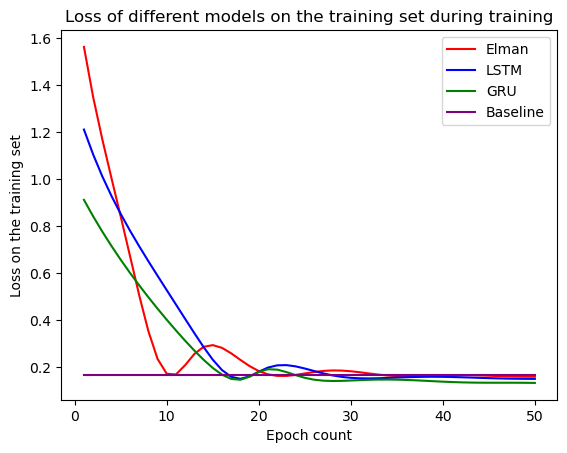

In [16]:
plt.figure()
colors = ['red', 'blue', 'green', 'purple']
for i in range(len(model_losses)):
    plt.plot(x_ax, model_losses[i], label=model_names[i], color=colors[i])
plt.xlabel("Epoch count")
plt.ylabel("Loss on the training set")
plt.title("Loss of different models on the training set during training")
plt.legend()
plt.show()

[array(0.16512376, dtype=float32), array(0.15385675, dtype=float32), array(0.1338294, dtype=float32), array(0.16753049, dtype=float32)]


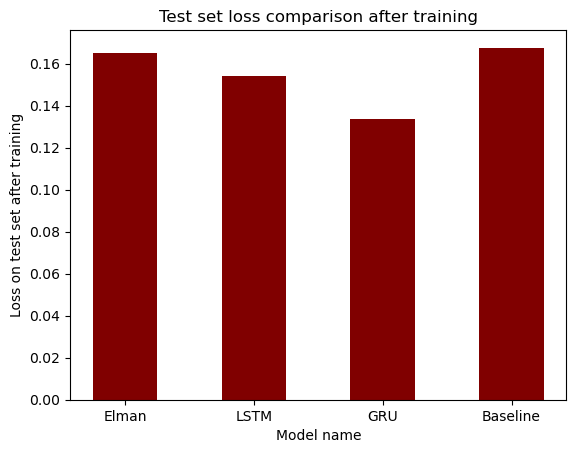

In [15]:
fig = plt.figure()


models.append(BadModel())
data = [criterion(models[i](X_test), torch.from_numpy(np.array(Y_test)).float()).detach().numpy() for i in range(len(model_names))]\

print(data)


plt.bar(model_names, data, color='maroon', width=0.5)
plt.xlabel("Model name")
plt.ylabel("Loss on test set after training")

plt.title("Test set loss comparison after training")
plt.show()
